# Wavelet-regularized potential reconstruction

Modeling of `MOLET` simulations.

__last update__: 16/08/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
import pickle as pkl
from pprint import pprint
import matplotlib.pyplot as plt
from copy import deepcopy
import corner
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize
%matplotlib inline
plt.rc('image', interpolation='none')

import jax.numpy as jnp

from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Parameters.covariance import FisherCovariance
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Inference.sampling import Sampler
from herculens.Analysis.plot import Plotter
from herculens.Util import param_util, model_util, molet_util, plot_util, jax_util, util

## Global settings

In [2]:
# Save modeling data on disk?
SAVE_MODELS = False
SAVE_HMC = True
SAVE_MODELS_REFINE = False  # includes MCMC sampling

# whether or not to stop the notebook before analytical 'refined' model
stop_after_main_model = True

# Type of the potential perturbations that we seek to recover
perturbation_type = 'dark_halo' # supported choices: 'dark_halo', 'GRF', 'discyness'

# Factor of pixel scale for the potential grid
potential_pixel_scale = 3  # = potential pixel size / data pixel size

# Strength of the regularization
regularization_strength = 'low'  # 'low', 'fiducial', 'high'

# Choice of type of PSF
psf_type = 'gaussian'  # 'gaussian', 'molet'

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=18, flux_vmin=5e-3, flux_vmax=1e0, res_vmax=6)

In [3]:
save_dir = 'results'
save_subdir = f'{regularization_strength}_regul_strength'

## Load the data set

### Imaging data, noise properties & coordinates

In [4]:
molet_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/wavelet-lensing-papers/paper_II/molet'
molet_simu_name = f'molet_sim_{perturbation_type}'

pixel_grid, noise, psf_molet, data, psi_grid_input, noise_real, _, _ \
    = molet_util.read_molet_simulation(molet_dir, molet_simu_name,
                                       use_true_noise_map=False, 
                                       subtract_offset=True,
                                       cut_psf=20)

npix, npix_y = pixel_grid.num_pixel_axes
pix_scl = pixel_grid.pixel_width  # arcsec / pixel
xgrid, ygrid = pixel_grid.pixel_coordinates

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")
print(f"exposure time : {noise.exposure_map} s")
print(f"background noise level : {noise.background_rms:.3f}")

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.956, 3.964) arcsec
y range    : (-3.956, 3.964) arcsec
exposure time : 9600.0 s
background noise level : 0.005


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:27: UserWarning: Using MOLET instrument 'gaussian03'.
  warnings.warn(f"Using MOLET instrument '{instrument_name}'.")
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:155: UserWarning: Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (what is the supersampling factor?).
  warnings.warn("Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (what is the supersampling factor?).")


### Point spread function

PSF kernel shape: (19, 19)


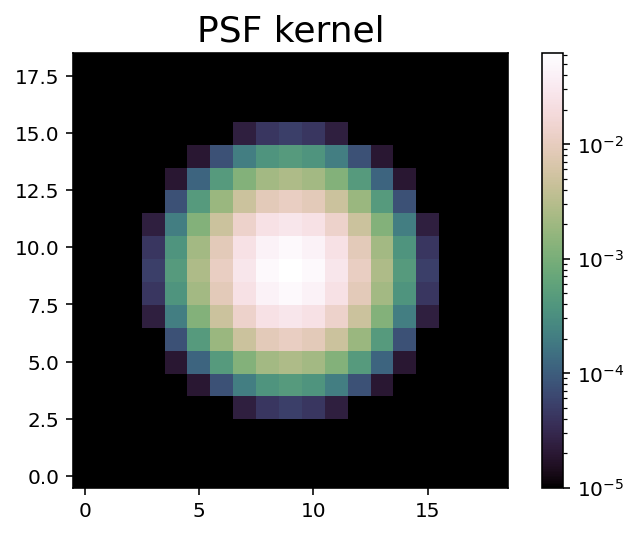

In [5]:
# PSF
if psf_type == 'gaussian':
    # Gaussian PSF
    psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)
elif psf_type == 'molet':
    # pixelated PSF used by MOLET
    psf = psf_molet
    
print("PSF kernel shape:", psf.kernel_point_source.shape)

plt.figure()
plt.title("PSF kernel", fontsize=18)
plt.imshow(psf.kernel_point_source, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

### Noise map

### Setup mass and light models

In [6]:
# Input lens mass model
kwargs_macro_lens_input = {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
kwargs_ext_shear_input = {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}
#phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_ext_shear_input['gamma1'], kwargs_ext_shear_input['gamma2'])
#print(f"Input shear strength: {gamma_ext:.3f} & direction: {phi_ext*180/np.pi:.3f}")
#phi, q = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], kwargs_macro_lens_input['e2'])
#print(f"Input macro axis ratio: {q:.3f} & direction: {phi*180/np.pi:.3f}")

# Fitted lens mass model
kwargs_pixelated_lens = {'pixel_scale_factor': potential_pixel_scale}
lens_model_fit = LensModel(['SIE', 'SHEAR', 'PIXELATED'],
                           kwargs_pixelated=kwargs_pixelated_lens)

# Input lens model
if 'dark_halo' not in perturbation_type:
    if psi_grid_input is None:
        raise
    lens_model_pert_input = LensModel(['PIXELATED'])
    lens_model_input = LensModel(['SIE', 'SHEAR', 'PIXELATED'])
    kwargs_lens_pert_input = {'pixels': psi_grid_input}
    kwargs_lens_input = [kwargs_macro_lens_input, kwargs_ext_shear_input, kwargs_lens_pert_input]
else:
    lens_model_pert_input = LensModel(['SIS'])
    lens_model_input = LensModel(['SIE', 'SHEAR', 'SIS'])
    kwargs_lens_pert_input = {'theta_E': 0.07, 'center_x': 1.9, 'center_y': -0.4}
    kwargs_lens_input = [kwargs_macro_lens_input, kwargs_ext_shear_input, kwargs_lens_pert_input]
    psi_grid_input = lens_model_input.potential(x_grid, y_grid, kwargs_lens_input, k=-1)
    
# Input source model 
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 10.0,
     'R_sersic': 0.8, 'n_sersic': 2, 'e1': -0.09, 'e2': 0.03,
     'center_x': 0.4, 'center_y': 0.15}
]
#phi_src, q_src = param_util.ellipticity2phi_q(kwargs_source_input[0]['e1'], kwargs_source_input[0]['e2'])
#print(f"Input source axis ratio: {q_src:.3f} & direction: {phi_src*180/np.pi:.3f}")

# Input lens light
if 'no_lens' in perturbation_type:
    no_lens_light = True
    lens_light_model_input = LightModel([])
    kwargs_lens_light_input = [{}]
else:
    no_lens_light = False
    lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
    kwargs_lens_light_input = [{'R_sersic': 1.9949292,
                    'amp': 12.620034,
                    'center_x': -0.00385393,
                    'center_y': -0.00458917,
                    'e1': 0.14911005,
                    'e2': -0.04016396,
                    'n_sersic': 1.9948864}
    ]

In [7]:
# here we extract, as a vector, the input values of each analytical parameters (lens and source) for corner plots
lens_image_analytical = LensImage(deepcopy(pixel_grid), psf, 
                                  lens_model_class=LensModel(['SIE', 'SHEAR']),
                                  source_model_class=LightModel(['SERSIC_ELLIPSE']))
kwargs_input_analytical = {'kwargs_lens': [kwargs_macro_lens_input, kwargs_ext_shear_input], 
                           'kwargs_source': kwargs_source_input}
#pprint(kwargs_input_analytical)
parameters_analytical = Parameters(lens_image_analytical, kwargs_input_analytical, 
                                   {'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{}]})
values_input_lenssrc = np.array(parameters_analytical.initial_values())
labels_input_lenssrc = parameters_analytical.names

### Create the image model

Including one to check input parameters w.r.t. the imaging data.

In [8]:
kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': 'grid'}

lens_image_input = LensImage(deepcopy(pixel_grid), psf, noise_class=deepcopy(noise),
                                lens_model_class=lens_model_input,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

lens_image_fit = LensImage(deepcopy(pixel_grid), psf, noise_class=deepcopy(noise),
                                lens_model_class=lens_model_fit,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

In [9]:
# Extract coordinate grids for pixelated potential
x_grid_fit, y_grid_fit = lens_image_fit.Grid.model_pixel_coordinates('lens')

# Extract the true perturbation potential on fitted grid
lens_model_pert_input.set_pixel_grid(pixel_grid.pixel_axes)
psi_grid_input_fitgrid = lens_model_pert_input.potential(x_grid_fit, y_grid_fit, [kwargs_lens_pert_input])

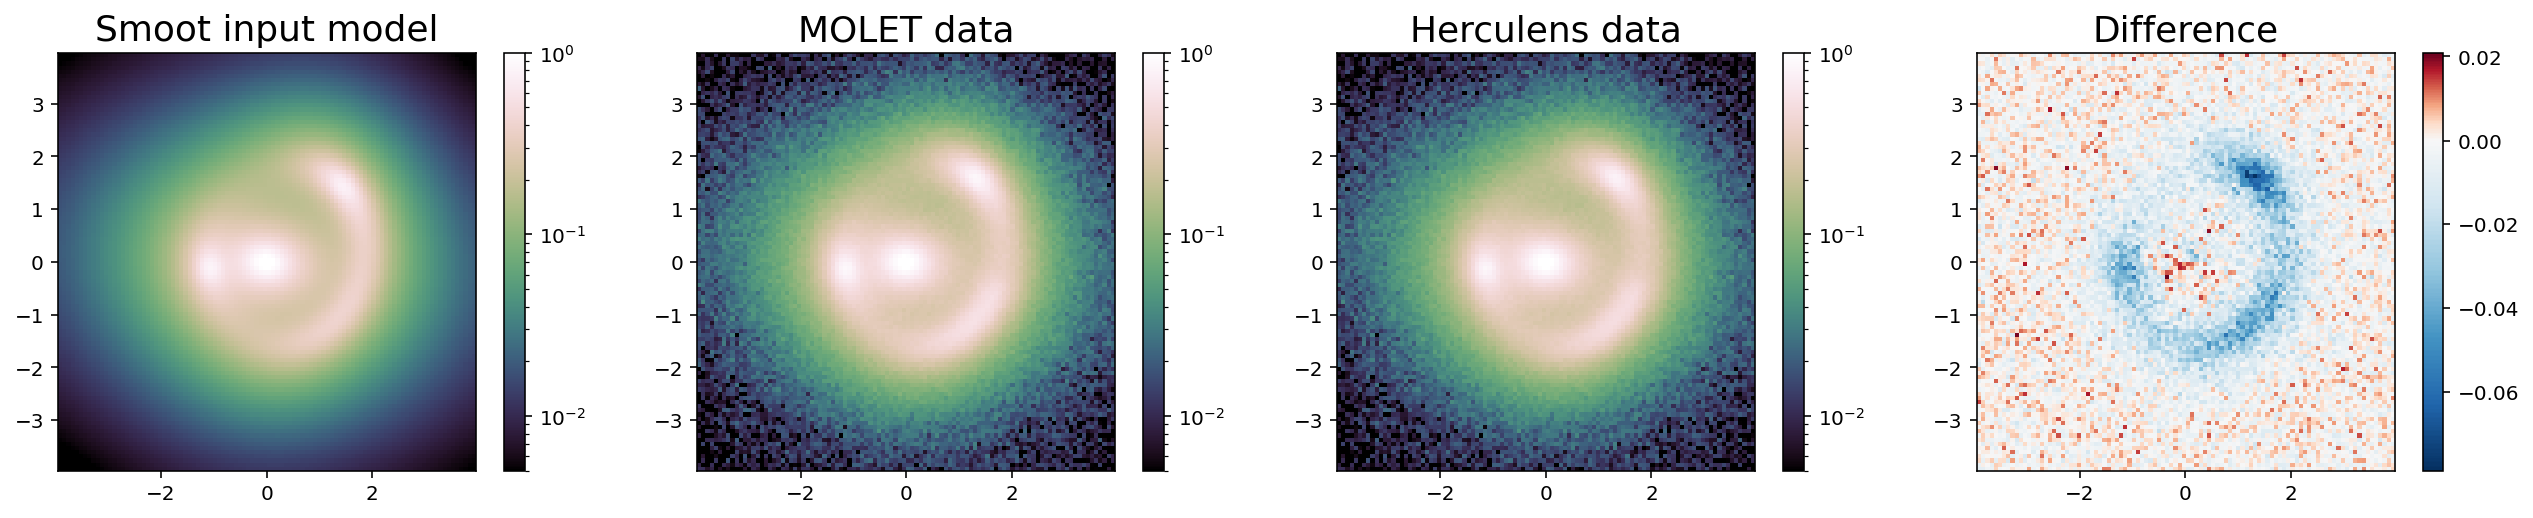

In [10]:
# Generate a lensed image based on source and lens models
kwargs_lens_smooth = [kwargs_macro_lens_input, kwargs_ext_shear_input, {'pixels': 1e-8*np.ones_like(x_grid_fit)}]
kwargs_smooth_input = {'kwargs_lens': kwargs_lens_smooth, 'kwargs_source': kwargs_source_input, 'kwargs_lens_light': kwargs_lens_light_input}
smooth_model_input = lens_image_fit.model(**kwargs_smooth_input)

# get the true source surface brightness
source_input = lens_image_fit.source_surface_brightness(kwargs_source_input,
                                                        de_lensed=True, unconvolved=True)

# get the equivalent data with Herculens to check for any mismtatch
kwargs_all_input = {'kwargs_lens': kwargs_lens_input, 'kwargs_source': kwargs_source_input, 'kwargs_lens_light': kwargs_lens_light_input}
herculens_model_input = np.array(lens_image_input.model(**kwargs_all_input))
herculens_data = herculens_model_input + noise_real


# inform the plotter for later use
plotter.set_data(data)
plotter.set_ref_source(source_input)
plotter.set_ref_pixelated_potential(psi_grid_input_fitgrid)

# Plot
fig, axes = plt.subplots(1, 4, figsize=(18, 3.5))
ax = axes[0]
ax.set_title("Smoot input model", fontsize=18)
im = ax.imshow(smooth_model_input, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("MOLET data", fontsize=18)
im = ax.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("Herculens data", fontsize=18)
im = ax.imshow(herculens_data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[3]
ax.set_title("Difference", fontsize=18)
im = ax.imshow(herculens_model_input - data, origin='lower', extent=extent, 
               cmap=plotter.cmap_res, norm=TwoSlopeNorm(0))
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

### Model _pre-fitting_

Just to get rid of any mismtatch between `Herculens` and `MOLET`.

Number of fitted parameters: 15


minimize.BFGS:   0%|          | 0/1 [00:00<?, ?it/s]

Initial loss: 13992.985
Number of data points in likelihood: 10000


minimize.BFGS: 100%|██████████| 1/1 [00:14<00:00, 14.85s/it]

Runtime: 14.862300157546997
Loss at best-fit: 5004.5684


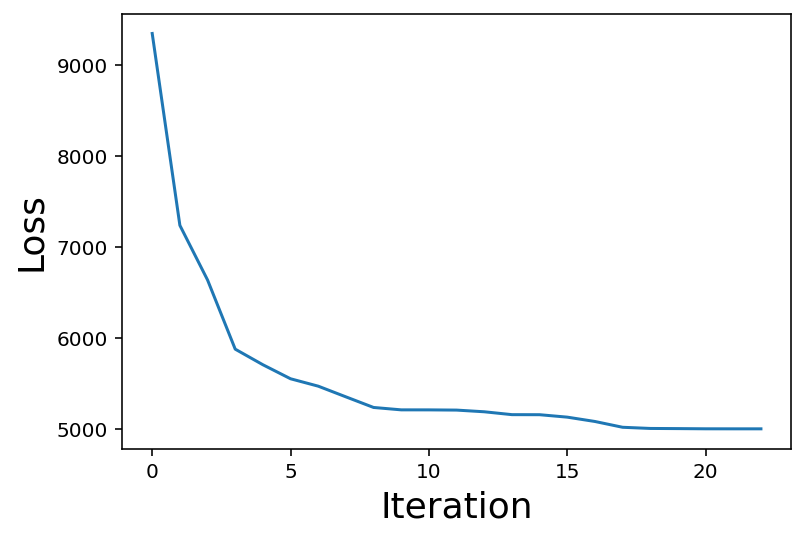

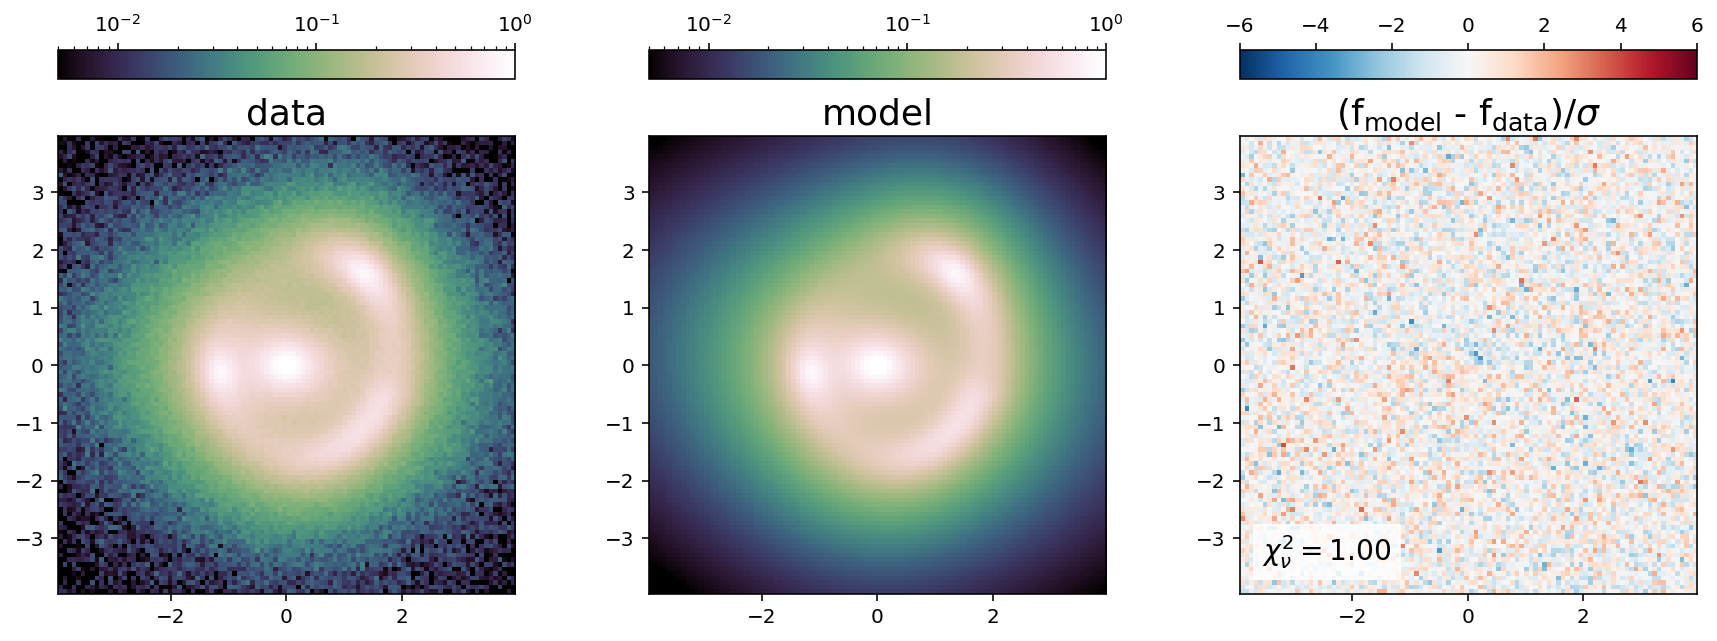

BEFORE pre-fit: [('theta_E', 1.6), ('e1', 0.15), ('e2', -0.04), ('gamma1', -0.01), ('gamma2', 0.03), ('amp', 10.0), ('R_sersic', 0.8), ('n_sersic', 2.0), ('e1', -0.09), ('e2', 0.03), ('center_x', 0.4), ('center_y', 0.15)]
AFTER pre-fit: [('theta_E', 1.6014799), ('e1', 0.1551304), ('e2', -0.037316985), ('gamma1', -0.008442943), ('gamma2', 0.03259301), ('amp', 11.364774), ('R_sersic', 0.7909584), ('n_sersic', 1.9531355), ('e1', -0.09209193), ('e2', 0.026813578), ('center_x', 0.39818358), ('center_y', 0.14732093)]


In [11]:
if 'dark_halo' in perturbation_type:
    kwargs_init = deepcopy(kwargs_all_input)
    kwargs_fixed = {
        'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0.0, 'dec_0': 0.}, {}], 
        'kwargs_source': [{}],
        'kwargs_lens_light': kwargs_lens_light_input,
    }
    if no_lens_light:
        kwargs_joint = {}
    else:
        kwargs_joint = {
            # fix lens center to lens light center
            'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
        }
    parameters_input = Parameters(lens_image_input, kwargs_init, kwargs_fixed, 
                                  kwargs_joint=kwargs_joint, kwargs_prior=None)
    print("Number of fitted parameters:", parameters_input.num_parameters)

    loss_input_fit = Loss(data, lens_image_input, parameters_input, prior_terms=None)
    print("Initial loss:", loss_input_fit(parameters_input.kwargs2args(kwargs_init)))
    print("Number of data points in likelihood:", loss_input_fit.likelihood_num_data_points)

    optimizer_input_fit = Optimizer(loss_input_fit, parameters_input)
    best_fit, logL, extra_fields, runtime \
        = optimizer_input_fit.minimize(method='BFGS', restart_from_init=True,
                             use_exact_hessian_if_allowed=False)
    print(f"Runtime: {runtime}")
    print("Loss at best-fit:", loss_input_fit(best_fit))
    kwargs_input_fit = deepcopy(parameters_input.best_fit_values(as_kwargs=True))
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
    ax.set_ylabel("Loss", fontsize=18)
    ax.set_xlabel("Iteration", fontsize=18)
    plt.show()

    fig = plotter.model_summary(lens_image_input, kwargs_input_fit, show_source=False)
    
    # update input value array as well
    print("BEFORE pre-fit:", list(zip(labels_input_lenssrc, values_input_lenssrc)))
    values_input_lenssrc = np.array(parameters_analytical.kwargs2args(kwargs_input_fit))
    print("AFTER pre-fit:", list(zip(labels_input_lenssrc, values_input_lenssrc)))

else:
    print("No pre-fitting possible!")
    kwargs_input_fit = kwargs_all_input
    
    print(list(zip(labels_input_lenssrc, values_input_lenssrc)))

In [12]:
#pprint(kwargs_all_input)
#pprint(kwargs_input_fit)

## Model fitting

### Prepare the parameters (initial values, constraints, etc.)

In [13]:
# initialize model parameters
kwargs_init = deepcopy(kwargs_input_fit)

# Either start from true input values or from a fully smooth fit results (smooth profile parameters only)
start_from_smooth_results = True

if start_from_smooth_results:
    filename_smooth = f'sumplot-real-{perturbation_type}-smooth_potential-smooth_source.pkl'
    with open(os.path.join(save_dir, filename_smooth), 'rb') as f:
        content = pkl.load(f)
        kwargs_fit_smooth = content[2]
    kwargs_init['kwargs_lens'][0]   = kwargs_fit_smooth['kwargs_lens'][0]    # SIE
    kwargs_init['kwargs_lens'][1]   = kwargs_fit_smooth['kwargs_lens'][1]    # external shear
    kwargs_init['kwargs_source'][0] = kwargs_fit_smooth['kwargs_source'][0]  # source

# initialize the pixelated component
psi_init_value = 1e-8
print("potential initial value:", psi_init_value)
psi_grid_init = psi_init_value * np.ones_like(psi_grid_input_fitgrid)
kwargs_init['kwargs_lens'][-1] = {'pixels': psi_grid_init}

kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0.0, 'dec_0': 0.}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': kwargs_input_fit['kwargs_lens_light'],  # lens light is fixed
}
if no_lens_light:
    kwargs_joint = {}
else:
    kwargs_joint = {
        # fix lens center to lens light center
        'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
    }
# set up some priors on parameters for multi-start optimization (not used within the loss function)
kwargs_prior = {
    'kwargs_lens': [
        {
            'theta_E': ['gaussian', 1.6, 0.2],
            'e1': ['gaussian', 0., 0.2],
            'e2': ['gaussian', 0., 0.2],
            'center_x': ['gaussian', 0., 0.1],
            'center_y': ['gaussian', 0., 0.1],
        },
        {
            'gamma1': ['gaussian', 0., 0.2],
            'gamma2': ['gaussian', 0., 0.2],
        },
        {}
    ],
    'kwargs_source': [
        {
            'amp': ['gaussian', 10., 5.],
            'R_sersic': ['gaussian', 0.6, 0.2],
            'n_sersic': ['gaussian', 2., 0.2],
            'e1': ['gaussian', 0., 0.2],
            'e2': ['gaussian', 0., 0.2],
            'center_x': ['gaussian', 0., 0.2],
            'center_y': ['gaussian', 0., 0.2],
        },
    ],
}

parameters = Parameters(lens_image_fit, kwargs_init, kwargs_fixed, 
                        kwargs_joint=kwargs_joint, kwargs_prior=kwargs_prior)
print("Number of fitted parameters:", parameters.num_parameters)

potential initial value: 1e-08
Number of fitted parameters: 1101


In [14]:
#random_params = parameters.draw_prior_samples(1)
#kwargs_random = parameters.args2kwargs(random_params[0])
#print(kwargs_random)

### Step 2: include perturbations to the lens potential with over-regularized pixels

#### Generate an arc mask (only to ease visualization)

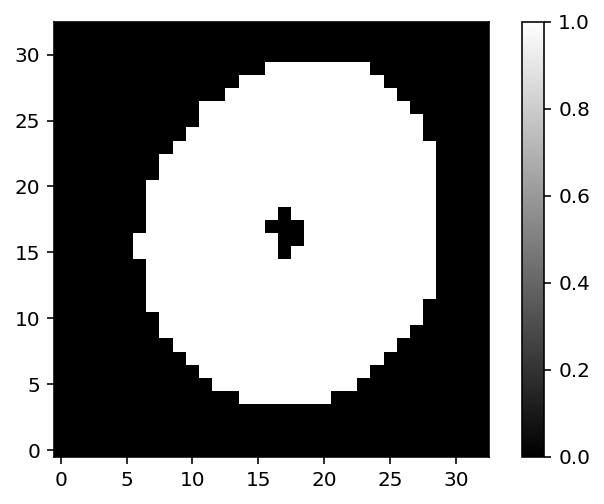

In [15]:
from scipy import ndimage

# generate the source mask based on SNR > 5
lensed_src = lens_image_fit.model(**kwargs_init, lens_light_add=False)
src_snr = lensed_src / np.sqrt(lens_image_fit.Noise.C_D_model(lensed_src))
src_mask = (src_snr > 5).astype(float)

# interpolate to potential grid
interp_psi_mask = jax_util.BicubicInterpolator(x_coords, y_coords, src_mask)
src_mask_interp = np.array(interp_psi_mask(y_grid_fit, x_grid_fit)).astype(bool).astype(float)

plt.figure()
plt.imshow(src_mask_interp, origin='lower', cmap='gray')
plt.colorbar()
plt.show()

#### Just some useful numbers to quote

In [16]:
# here we compute the relative magnitude of potential perturbations
# w.r.t. to the macro potential within the mask
macro_pot_input_fitgrid = lens_model_fit.potential(x_grid_fit, y_grid_fit, 
                                                   [kwargs_macro_lens_input, kwargs_ext_shear_input, {}], 
                                                   k=[True, True, False])
macro_pot_input_fitgrid = np.array(macro_pot_input_fitgrid)
macro_pot_input_fitgrid[macro_pot_input_fitgrid < 1e-1] = 1e-1

psi_relative = np.abs(psi_grid_input_fitgrid) / macro_pot_input_fitgrid
psi_pert_perc = psi_relative[src_mask_interp==1].mean() * 100

print(f"Mean perturbation % wrt smooth potential: {psi_pert_perc:.3f} [%]")

model_source = lens_image_fit.model(**parameters.current_values(as_kwargs=True), lens_light_add=False)
noise_map_source = np.sqrt(lens_image_fit.Noise.C_D_model(model_source, force_recompute=True))
snr_map = np.abs(model_source) / noise_map_source
print("Source mean SNR:", snr_map[src_mask==1].mean())

Mean perturbation % wrt smooth potential: 6.432 [%]
Source mean SNR: 19.367378


#### Estimate the noise variance in the lens potential and in wavelet space

In [17]:
#%%time
#pot_noise_st_deriv, pot_noise_bl_deriv = model_util.pixel_pot_noise_map_deriv(lens_image_fit, 
#                                                           parameters.current_values(as_kwargs=True), 
#                                                           cut=1e-10,
#                                                            wavelet_type_list=['starlet', 'battle-lemarie-3'])

In [18]:
%%time
pot_noise_st_oper, pot_noise_bl_oper \
    = model_util.data_noise_to_wavelet_potential(data, lens_image_fit, 
                                                 parameters.current_values(as_kwargs=True),
                                                 wavelet_type_list=['starlet', 'battle-lemarie-3'], 
                                                 method='MC', num_samples=6000, seed=8, verbose=False)

CPU times: user 32.6 s, sys: 1.1 s, total: 33.7 s
Wall time: 19.6 s


Number of data points in likelihood: 10000
Initial loss 6872.099


optax.adabelief: 100%|██████████| 500/500 [00:14<00:00, 34.41it/s]


Runtime: 14.531527996063232
Loss at best-fit: 6303.5454


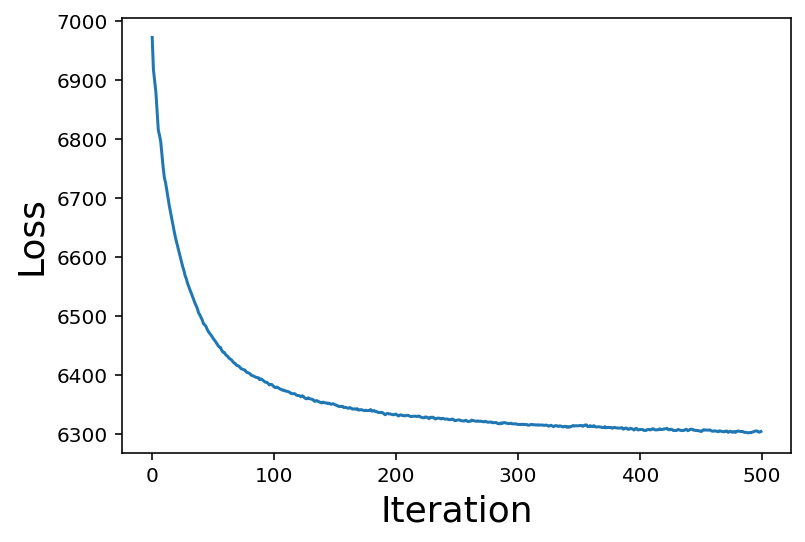

In [19]:
# Create loss
loss_pixpot_fit = Loss(data, lens_image_fit, parameters, 

                       regularization_terms=[
                           'l1_starlet_potential', 
                           'l1_battle_potential',
                       ],
                       # uniform over-regularization
                       regularization_strengths=[
                           10,
                           20,
                           #1e-1,
                           #1e-1,
                       ],
                       regularization_weights=[
                           pot_noise_st_oper,
                           pot_noise_bl_oper
                           #np.ones_like(pot_noise_st_oper), 
                           #np.ones_like(pot_noise_bl_oper),
                       ],
                       prior_terms=None)
print("Number of data points in likelihood:", loss_pixpot_fit.likelihood_num_data_points)

# Optimizer
optimizer_pixpot_fit = Optimizer(loss_pixpot_fit, parameters)
print("Initial loss", loss_pixpot_fit(parameters.current_values()))
loss_pixpot_fit.gradient(parameters.current_values()).block_until_ready();  # allows to JIT it earlier on
#print("Initial gradient", optimizer_pixpot_fit.gradient(parameters.initial_values()).block_until_ready())

optimizer_type = 'optax'

if optimizer_type == 'minimize':
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit.minimize(method='BFGS', maxiter=None, 
                                        restart_from_init=False)
elif optimizer_type == 'optax':
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit.optax(algorithm='adabelief', progress_bar=True,
                                     max_iterations=500, 
                                     init_learning_rate=1e-4,
                                     schedule_learning_rate=True,
                                     restart_from_init=False)

print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_pixpot_fit(best_fit))

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

kwargs_pixpot_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

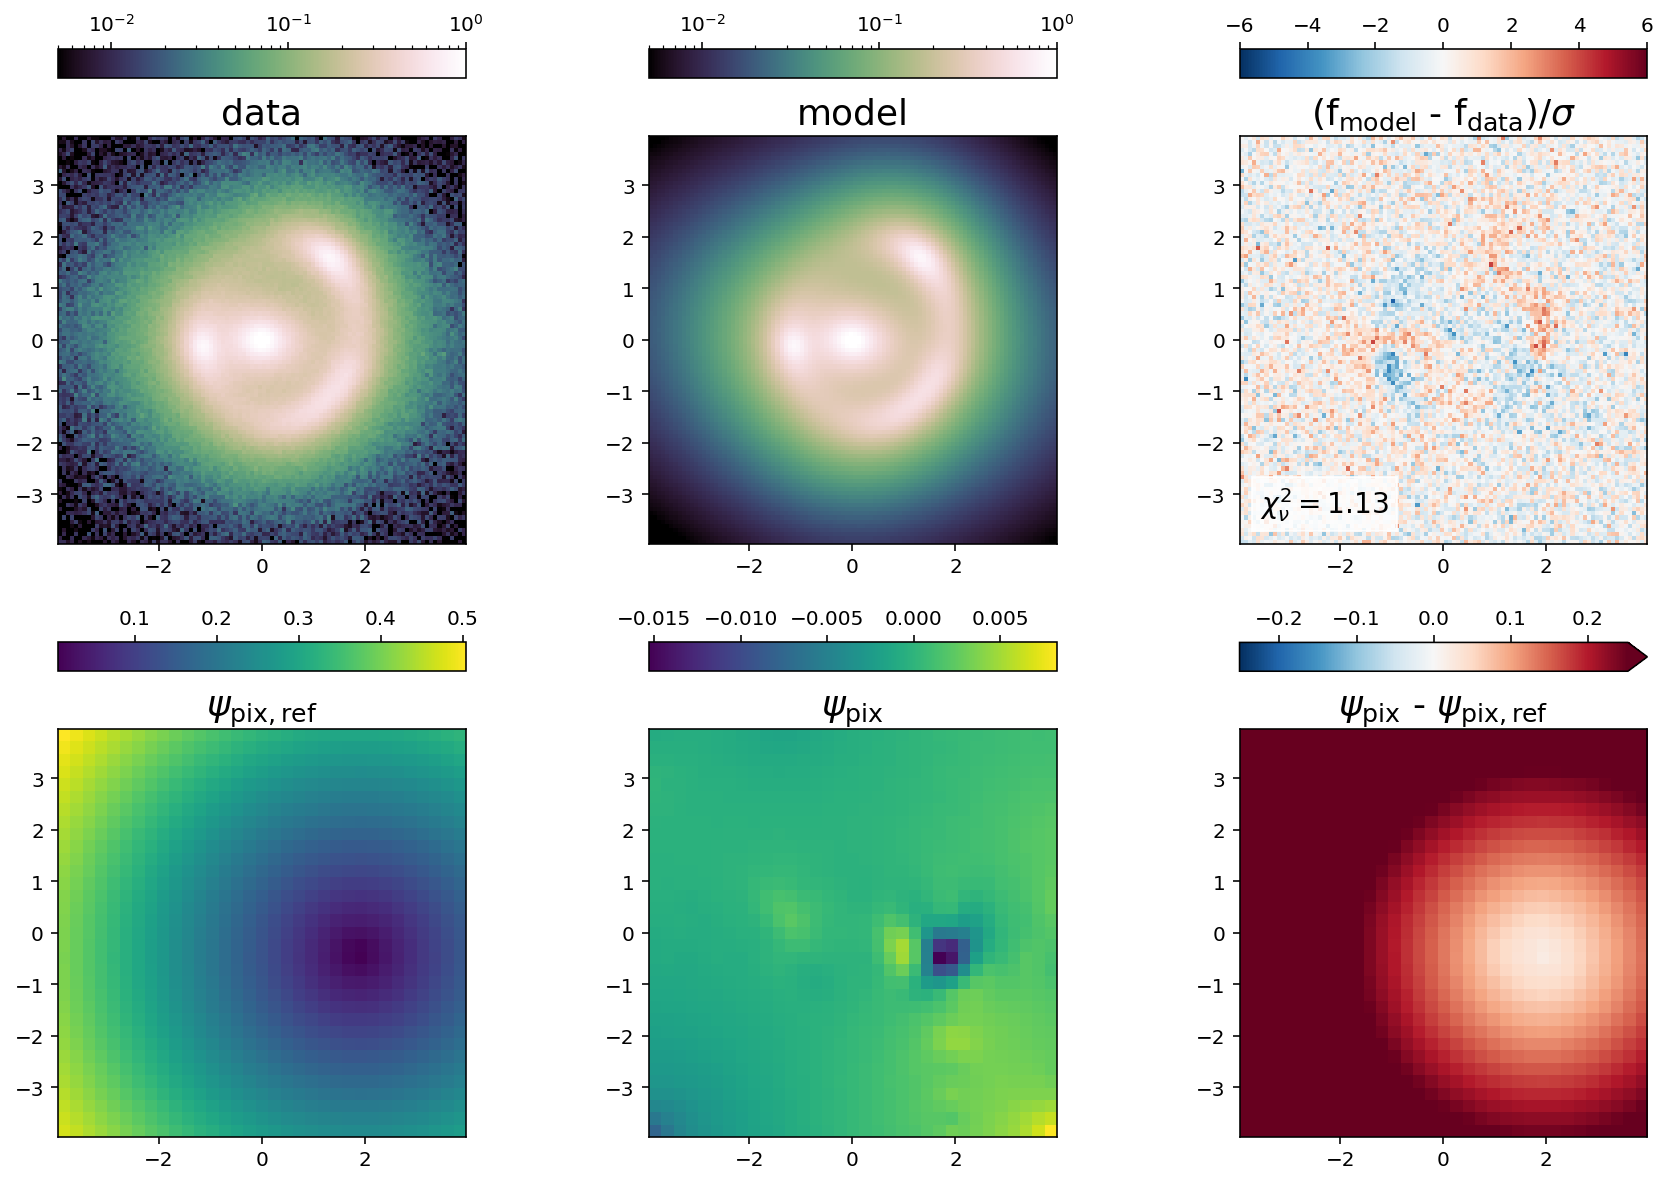

In [20]:
shift_pixelated_potential = 'min' if 'dark_halo' in perturbation_type else 'mean'
fig = plotter.model_summary(lens_image_fit, kwargs_pixpot_fit,
                            show_source=False, show_lens_potential=True, show_lens_others=False, 
                            #potential_mask=src_mask_interp,
                            #shift_pixelated_potential=shift_pixelated_potential,
                            #vmin_pot=-0.1, vmax_pot=0.1,
                            )

In [21]:
print("LL =", -loss_pixpot_fit.log_likelihood(lens_image_fit.model(**kwargs_pixpot_fit)))
print("REG =", -loss_pixpot_fit.log_regularization(kwargs_pixpot_fit))

pprint(kwargs_pixpot_fit['kwargs_lens'][:2])
pprint(kwargs_pixpot_fit['kwargs_source'])

LL = 5652.955
REG = 650.58997
[{'center_x': -0.00385393,
  'center_y': -0.00458917,
  'e1': array(0.21545103, dtype=float32),
  'e2': array(-0.05371497, dtype=float32),
  'theta_E': array(1.6549014, dtype=float32)},
 {'dec_0': 0.0,
  'gamma1': array(0.01332326, dtype=float32),
  'gamma2': array(0.02999947, dtype=float32),
  'ra_0': 0.0}]
[{'R_sersic': array(0.79488254, dtype=float32),
  'amp': array(12.420724, dtype=float32),
  'center_x': array(0.35847285, dtype=float32),
  'center_y': array(0.16748664, dtype=float32),
  'e1': array(-0.10881712, dtype=float32),
  'e2': array(0.02643514, dtype=float32),
  'n_sersic': array(1.8691919, dtype=float32)}]


### Step 4: Re-optimize pixelated perturbations, with final regularization strength

In [22]:
pot_noise_st_oper2, pot_noise_bl_oper2 \
    = model_util.data_noise_to_wavelet_potential(data, lens_image_fit, 
                                                 parameters.current_values(as_kwargs=True),
                                                 wavelet_type_list=['starlet', 'battle-lemarie-3'],
                                                 method='MC', num_samples=6000, seed=8, verbose=True)

compute DsDpsi: 0.5891430377960205
compute B: 8.106231689453125e-06
compute D: 0.08072590827941895
loop over MC samples for wavelet 'starlet': 6.746455669403076
loop over MC samples for wavelet 'battle-lemarie-3': 7.0975730419158936


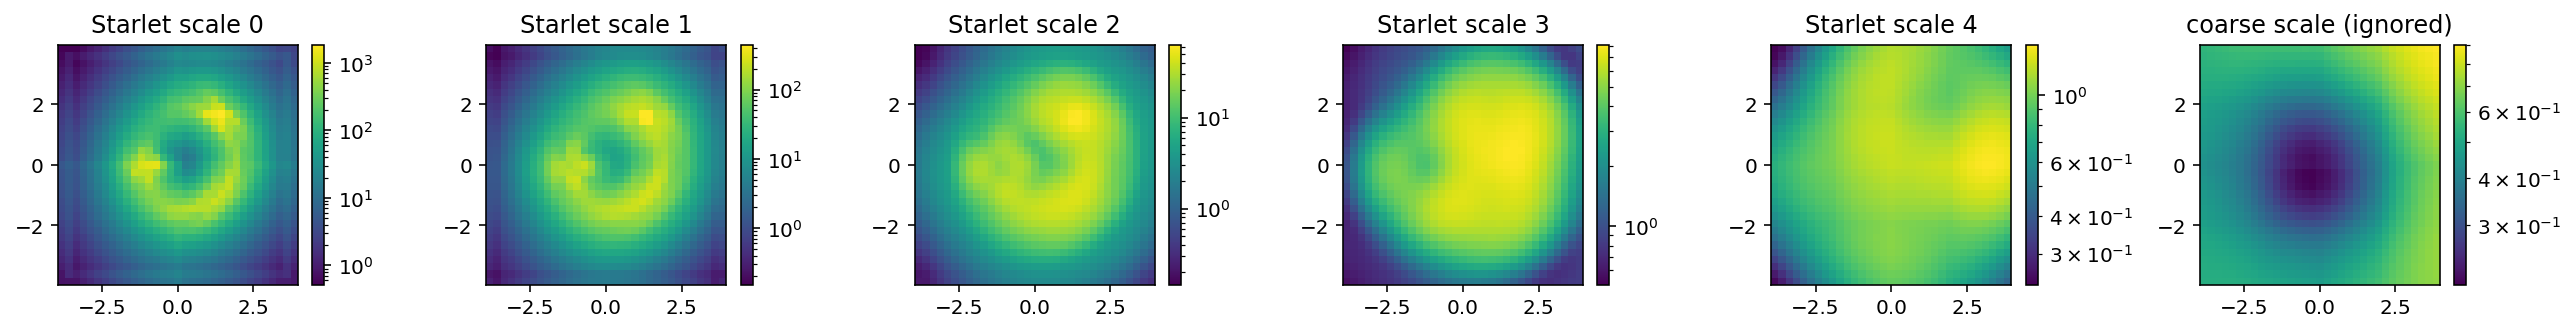

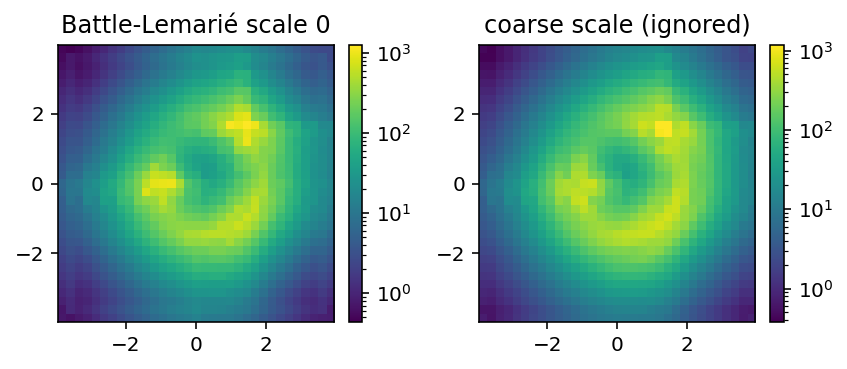

In [23]:
pot_noise_st_plot = np.copy(pot_noise_st_oper2)
pot_noise_bl_plot = np.copy(pot_noise_bl_oper2)

fig, axes = plt.subplots(1, pot_noise_st_plot.shape[0], figsize=(18, 4))
for k in range(pot_noise_st_plot.shape[0]):
    ax = axes[k]
    if k == pot_noise_st_plot.shape[0]-1:
        ax.set_title(f"coarse scale (ignored)")
    else:
        ax.set_title(f"Starlet scale {k}")
    im = ax.imshow(pot_noise_st_plot[k], origin='lower', extent=extent,
                   #cmap='Spectral_r', norm=TwoSlopeNorm(0)
                   cmap='viridis', norm=LogNorm()
                  )
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(1, pot_noise_bl_plot.shape[0], figsize=(6, 4))
for k in range(pot_noise_bl_plot.shape[0]):
    ax = axes[k]
    if k == pot_noise_bl_plot.shape[0]-1:
        ax.set_title(f"coarse scale (ignored)")
    else:
        ax.set_title(f"Battle-Lemarié scale {k}")
    im = ax.imshow(pot_noise_bl_plot[k], origin='lower', extent=extent, 
                   #cmap='Spectral_r', norm=TwoSlopeNorm(0)
                   cmap='viridis', norm=LogNorm()
                  )
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [24]:
# save noise in wavelet space for example plot
save_wavelet_scales = False
if save_wavelet_scales:
    file_name = f'noise_pixpot_example-scale_{potential_pixel_scale}-smooth_source.pkl'
    with open(os.path.join(save_dir, file_name), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            data, lens_image_fit, parameters.current_values(as_kwargs=True),
            pot_noise_st_oper2, 
            pot_noise_bl_oper2
        ]
        pkl.dump(pkl_content, f, pkl_protocol)

Number of data points in likelihood: 10000
Initial loss 5720.315


optax.adabelief: 100%|██████████| 1000/1000 [00:29<00:00, 34.31it/s]


Runtime: 29.146941900253296
Loss at best-fit: 5171.609


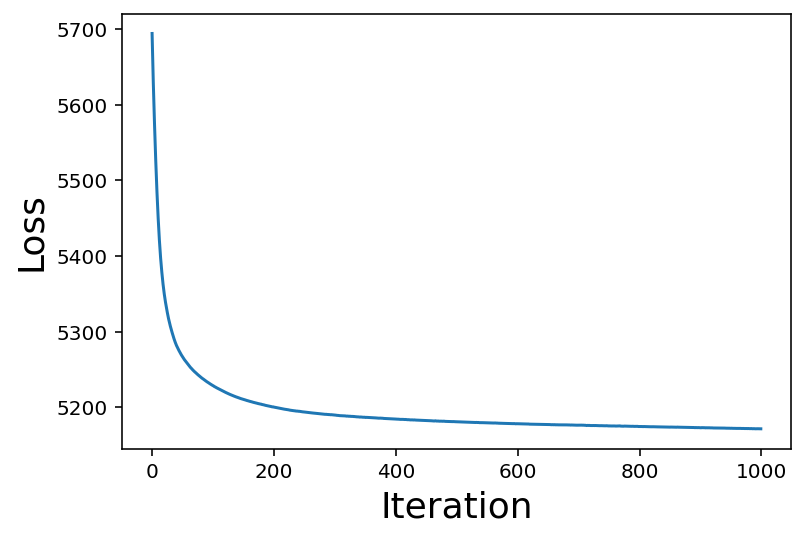

In [25]:
if regularization_strength == 'fiducial':
    regul_strength = 3
elif regularization_strength == 'low':
    regul_strength = 1
elif regularization_strength == 'high':
    regul_strength = 5

# Create loss
loss_pixpot_fit2 = Loss(data, lens_image_fit, parameters, 

                       regularization_terms=[
                           'l1_starlet_potential', 
                           'l1_battle_potential'
                       ], 
                       regularization_strengths=[
                           regul_strength, 
                           regul_strength + 1,
                       ],
                       regularization_weights=[
                           pot_noise_st_oper2, 
                           pot_noise_bl_oper2
                       ],
                        
                       prior_terms=None)
print("Number of data points in likelihood:", loss_pixpot_fit2.likelihood_num_data_points)

# Optimizer
optimizer_pixpot_fit2 = Optimizer(loss_pixpot_fit2, parameters)
print("Initial loss", loss_pixpot_fit2(parameters.current_values()))
loss_pixpot_fit2.gradient(parameters.current_values()).block_until_ready();  # allows to JIT it earlier on
#print("Initial gradient", optimizer_pixpot_fit2.gradient(parameters.current_values()).block_until_ready())

optimizer_type = 'optax'

if optimizer_type == 'minimize':
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit2.minimize(method='BFGS', maxiter=None, 
                                        restart_from_init=False)
elif optimizer_type == 'optax':
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit2.optax(algorithm='adabelief', progress_bar=True,
                                     max_iterations=1000, 
                                     init_learning_rate=1e-4,
                                      schedule_learning_rate=True,
                                     restart_from_init=False)

print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_pixpot_fit2(best_fit))

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

kwargs_pixpot_fit2 = deepcopy(parameters.best_fit_values(as_kwargs=True))

delta_psi shift by min: -0.030637637


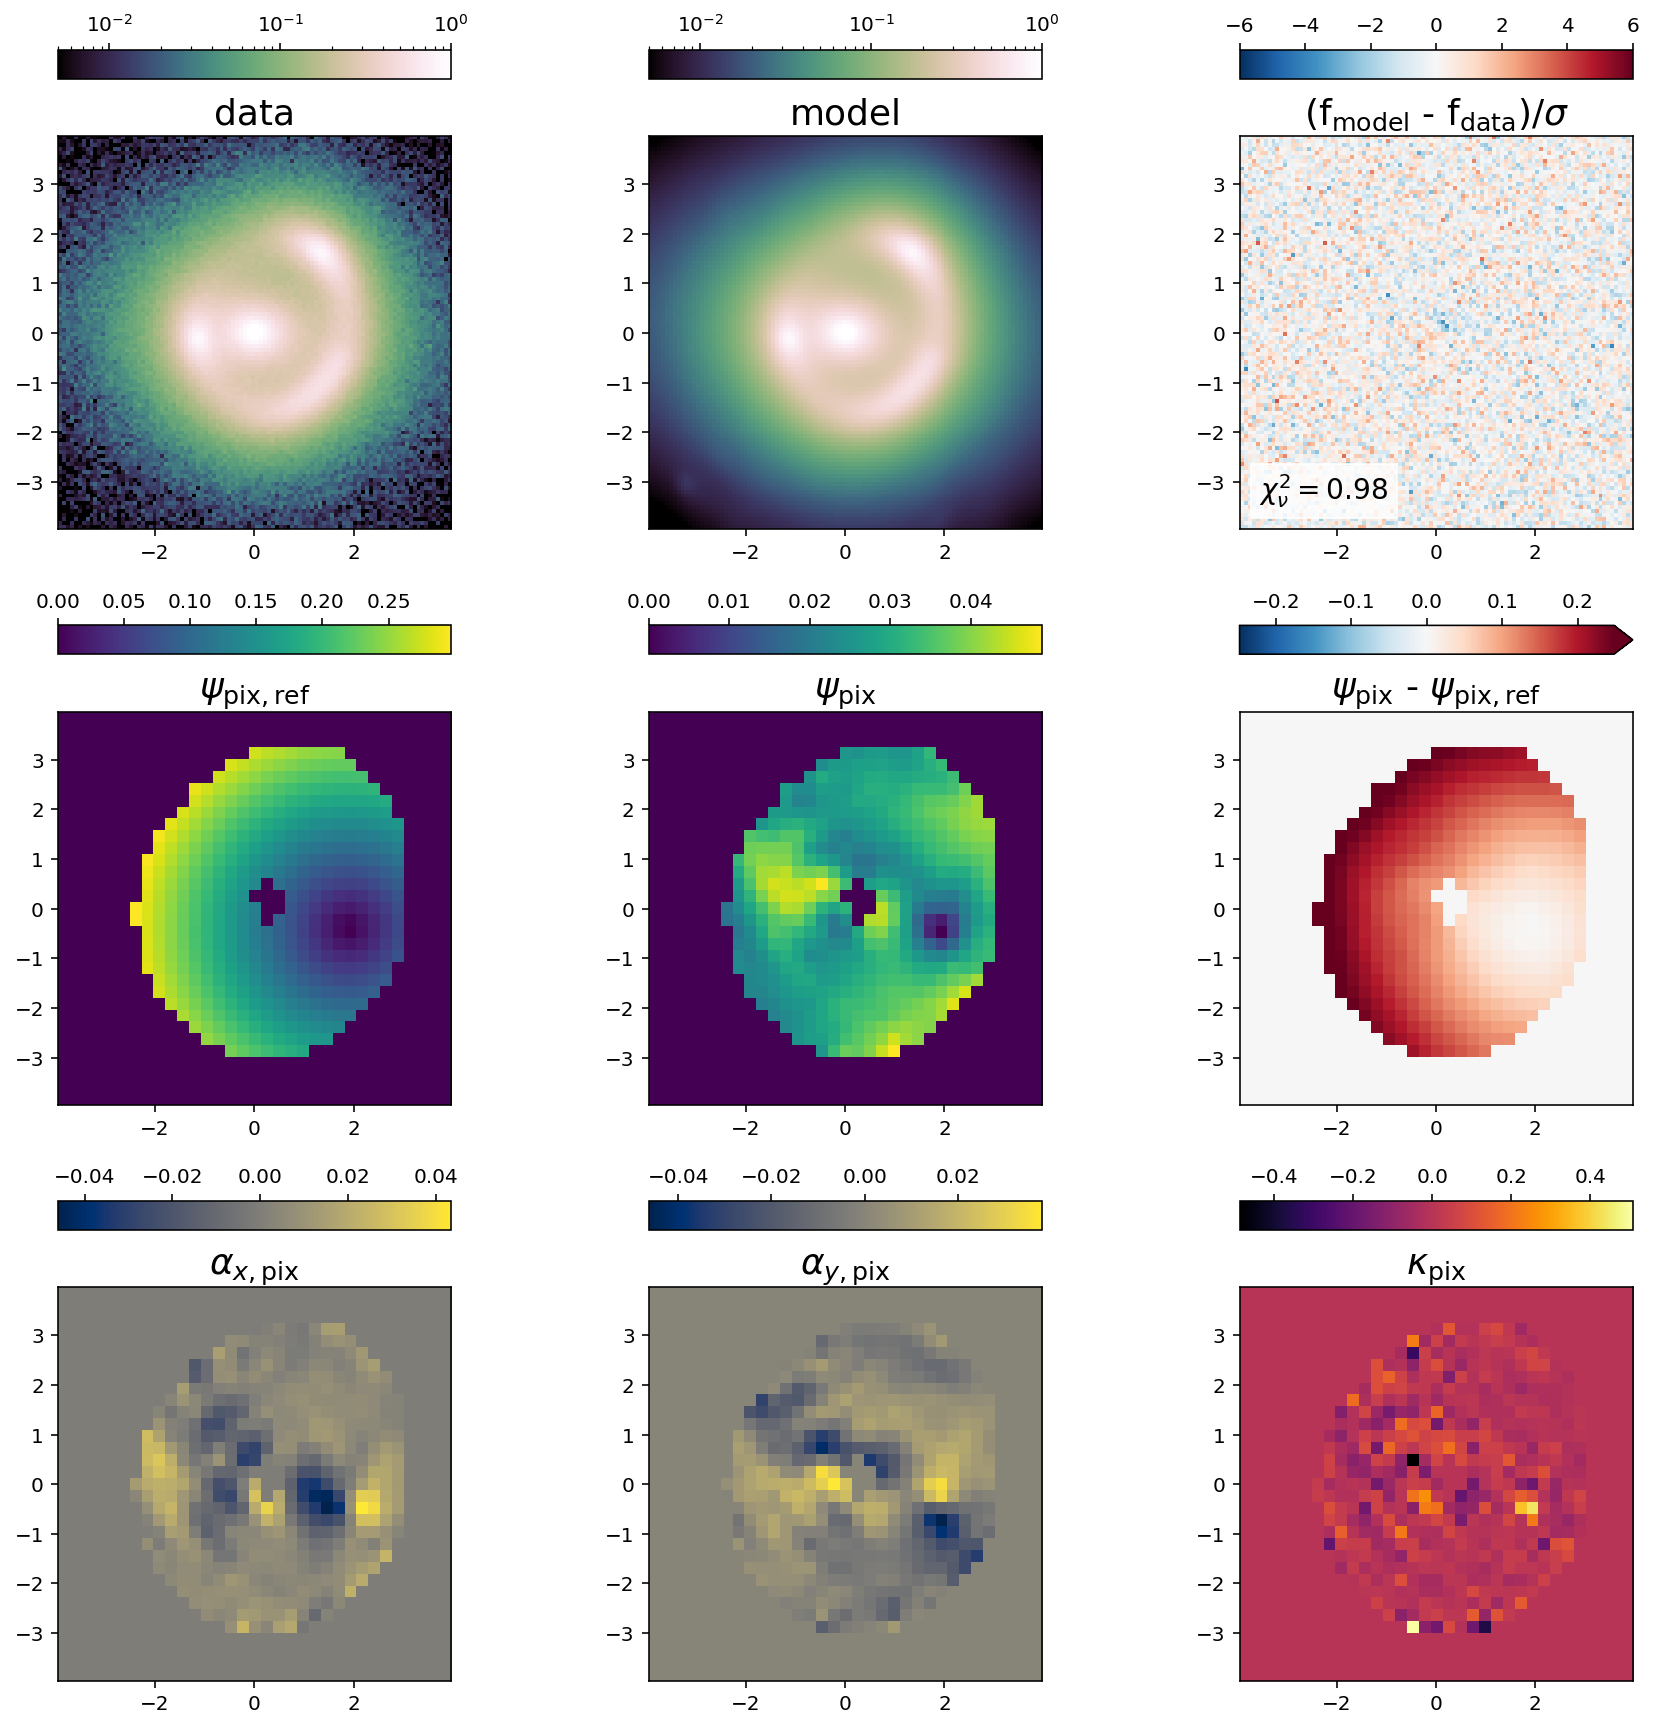

In [26]:
shift_pixelated_potential = 'min' if 'dark_halo' in perturbation_type else 'mean'
fig = plotter.model_summary(lens_image_fit, kwargs_pixpot_fit2, 
                            show_source=False, show_lens_potential=True, show_lens_others=True, 
                            potential_mask=src_mask_interp,
                            shift_pixelated_potential=shift_pixelated_potential
                           )
plt.show()

In [27]:
print("LL =", -loss_pixpot_fit2.log_likelihood(lens_image_fit.model(**kwargs_pixpot_fit2)))
print("REG =", -loss_pixpot_fit2.log_regularization(kwargs_pixpot_fit2))

pprint(kwargs_pixpot_fit2['kwargs_lens'][:2])
pprint(kwargs_pixpot_fit2['kwargs_source'])

LL = 4892.094
REG = 279.51312
[{'center_x': -0.00385393,
  'center_y': -0.00458917,
  'e1': array(0.20854232, dtype=float32),
  'e2': array(-0.06623393, dtype=float32),
  'theta_E': array(1.6531817, dtype=float32)},
 {'dec_0': 0.0,
  'gamma1': array(0.01072127, dtype=float32),
  'gamma2': array(0.02306571, dtype=float32),
  'ra_0': 0.0}]
[{'R_sersic': array(0.79323864, dtype=float32),
  'amp': array(12.336059, dtype=float32),
  'center_x': array(0.3582, dtype=float32),
  'center_y': array(0.16927093, dtype=float32),
  'e1': array(-0.1029722, dtype=float32),
  'e2': array(0.03352037, dtype=float32),
  'n_sersic': array(1.8900994, dtype=float32)}]


In [28]:
#pprint(kwargs_pixpot_fit['kwargs_lens'][-1])
#pprint(kwargs_pixpot_fit2['kwargs_lens'][-1])

### Estimation of parameters (co)variance

In [29]:
num_lens = 5
num_src = 7

values_bestfit_lenssrc = np.concatenate([best_fit[:num_lens], best_fit[-num_src:]])
print(values_bestfit_lenssrc.shape)

(12,)


In [30]:
#if SAVE_MCMC or SAVE_MODELS:
model_covar = FisherCovariance(parameters, loss_pixpot_fit2)

# Fisher information matrices
model_covar.compute_fisher_information()  # can take time
full_fisher_matrix = model_covar.fisher_matrix
fisher_pixpot, fisher_lenssrc = model_covar.split_matrix(full_fisher_matrix, num_lens, num_src)

# covariance matrices
cov_matrix_pixpot  = model_covar.fisher2covar(fisher_pixpot, inversion='diag')
cov_matrix_lenssrc = model_covar.fisher2covar(fisher_lenssrc, inversion='full')

## Save results for plotting and analysis

In [31]:
base_filename = f'-real-{perturbation_type}-scale_{potential_pixel_scale}-smooth_source'

if start_from_smooth_results is True:
    base_filename += f'-init_from_smooth'

if SAVE_MODELS:
    with open(os.path.join(save_dir, save_subdir, 'sumplot'+base_filename+'.pkl'), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            # data
            data,
            
            # model
            lens_image_fit, 
            
            # parameter values
            kwargs_pixpot_fit2, 
            kwargs_input_fit,
            
            # pixelated potential
            src_mask_interp,
            None, #potential_noise_map,
            psi_grid_input,
            psi_grid_input_fitgrid,
            
            # error estimations
            full_fisher_matrix,
            cov_matrix_pixpot,
            cov_matrix_lenssrc,
            
            # parameter vectors for corner plot
            values_input_lenssrc,
            values_bestfit_lenssrc,
            labels_input_lenssrc,
        ]
        pkl.dump(pkl_content, f, pkl_protocol)

## HMC sampling for all parameters

In [32]:
sampler = Sampler(loss_pixpot_fit2, parameters)

seed_hmc = 10
inv_mass_matrix = None #fisher_pixpot

num_chains = 1
num_warmup, num_samples = 100, 1600
samples_hmc, logL, extra_fields, runtime \
    = sampler.hmc_blackjax(seed_hmc, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, 
                           restart_from_init=False, sampler_type='NUTS', use_stan_warmup=True,
                           step_size=1e-3, inv_mass_matrix=inv_mass_matrix, num_integ_steps=30)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_hmc.shape}")

Runtime: 12130.306094169617
Samples shape: (1600, 1101)


(1600, 1101)


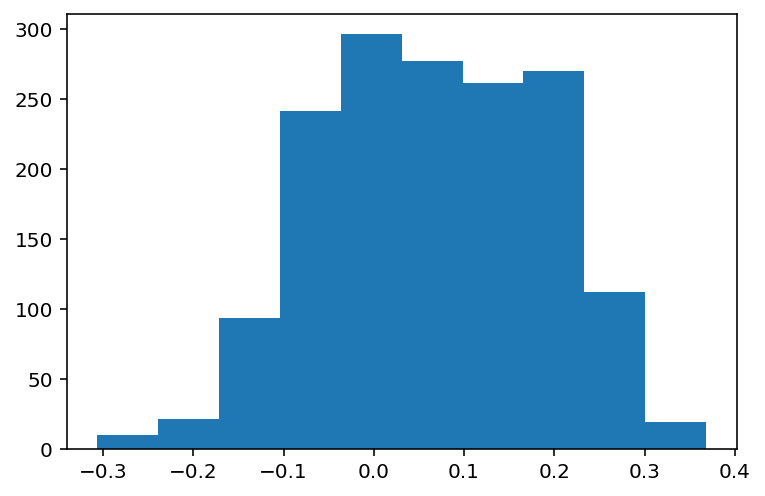

In [33]:
print(samples_hmc.shape)

plt.hist(samples_hmc[:, 100])
plt.show()

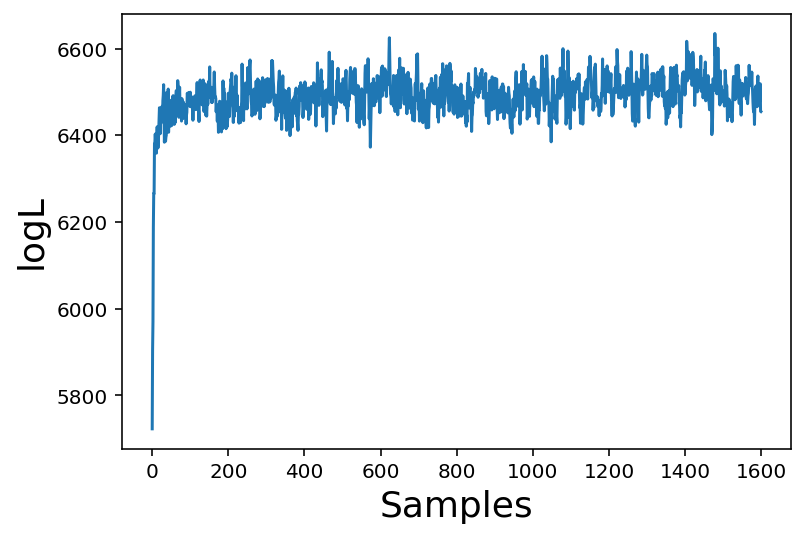

In [34]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(logL)), logL)
ax.set_ylabel("logL", fontsize=18)
ax.set_xlabel("Samples", fontsize=18)
plt.show()

In [35]:
idx_map = int(np.argmax(logL))
print(idx_map)

1478


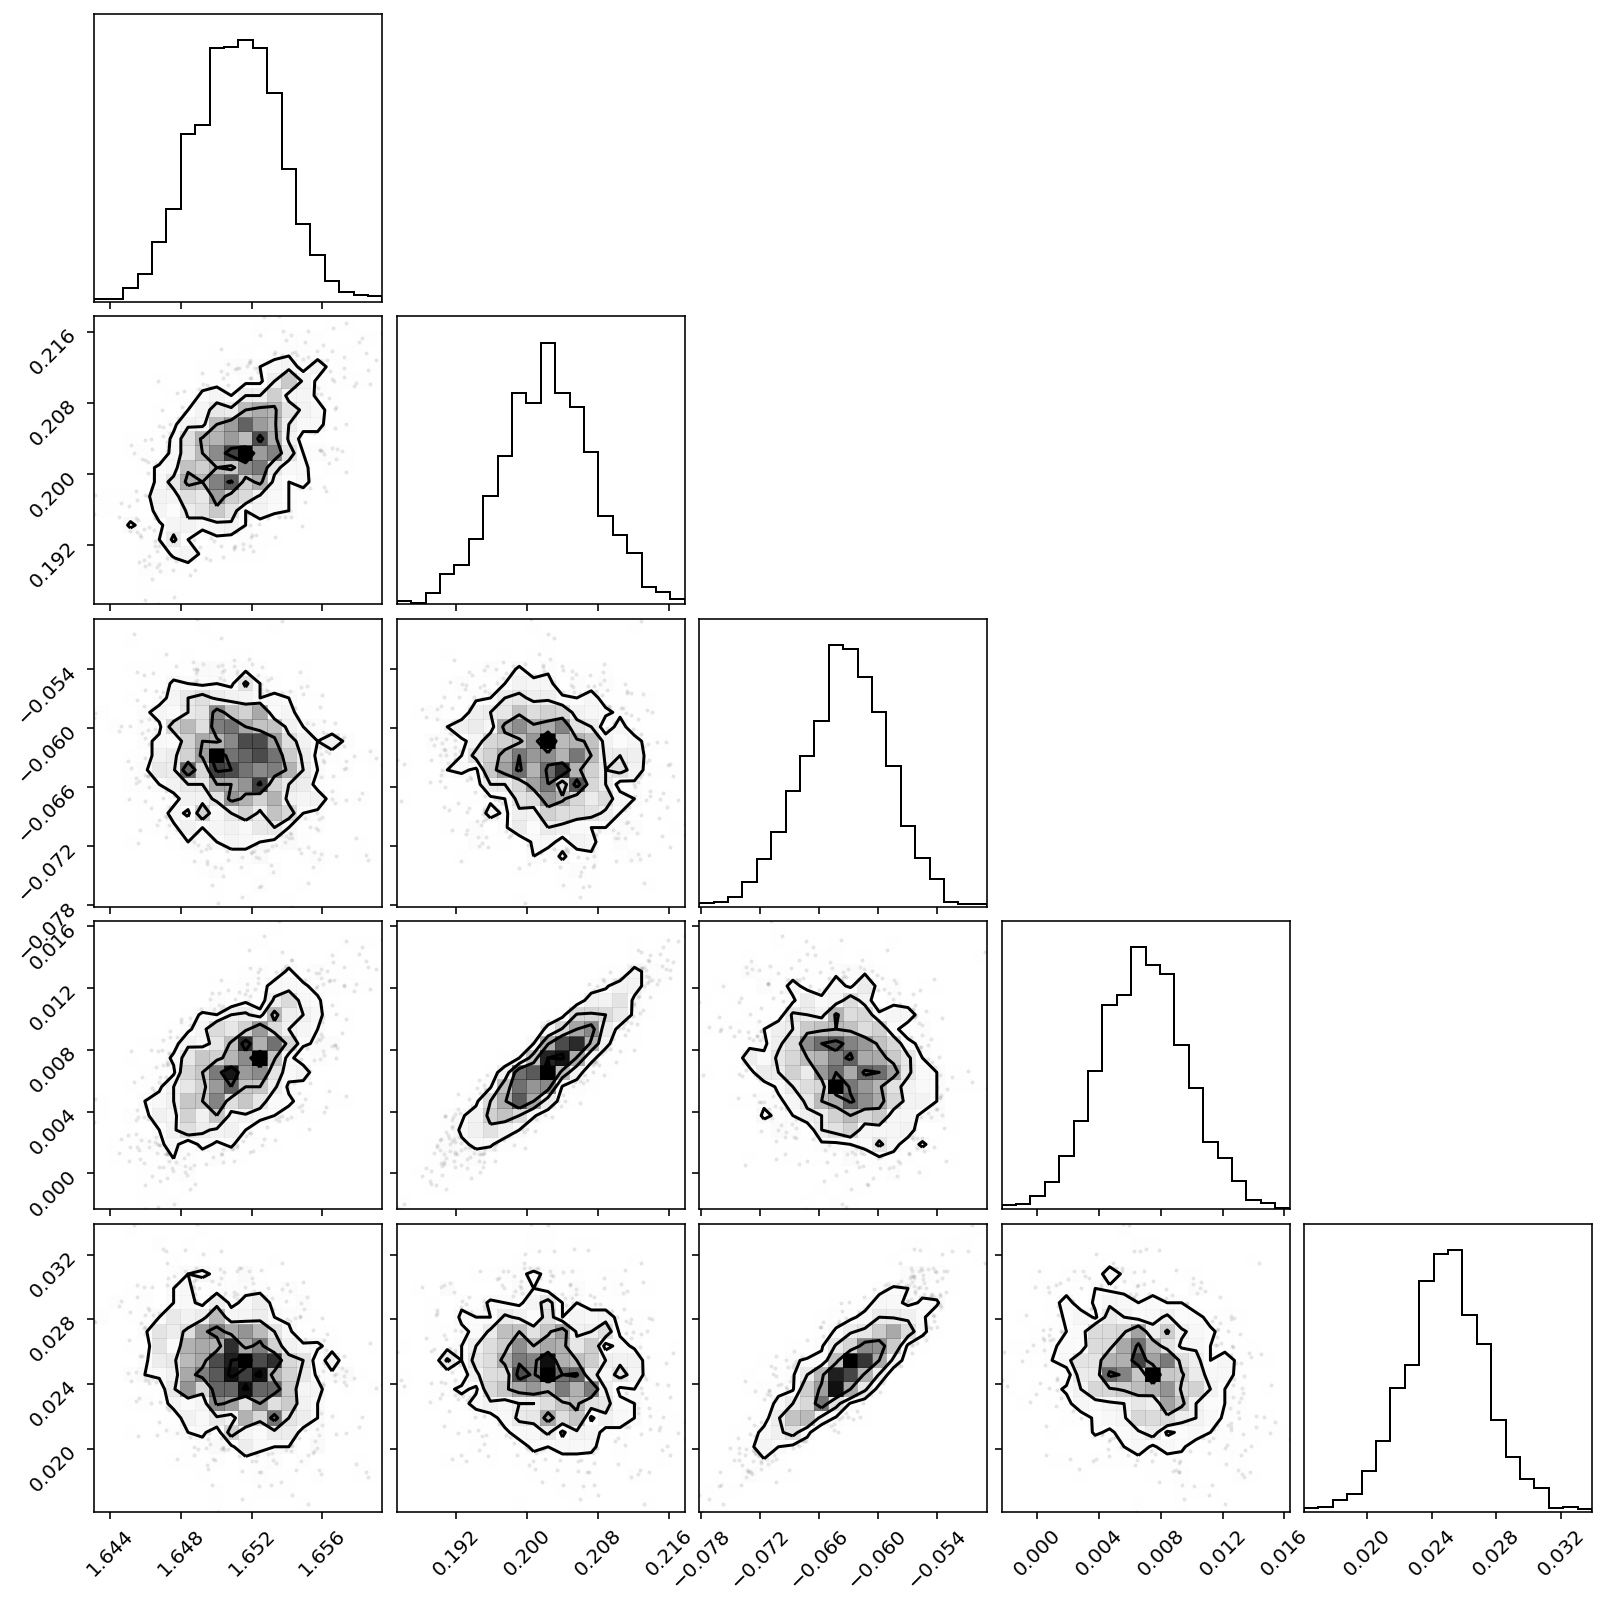

In [36]:
import corner

corner.corner(np.array(samples_hmc[100:, :5]))
plt.show()

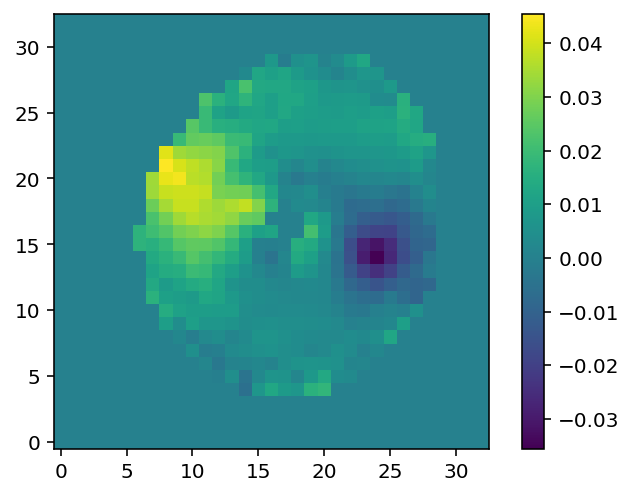

In [37]:
bestfit = kwargs_pixpot_fit2['kwargs_lens'][-1]['pixels']
map_hmc = samples_hmc[idx_map, 5:-7].reshape(*psi_grid_input_fitgrid.shape)
mean_hmc = np.mean(samples_hmc, axis=0)[5:-7].reshape(*psi_grid_input_fitgrid.shape)
median_hmc = np.median(samples_hmc, axis=0)[5:-7].reshape(*psi_grid_input_fitgrid.shape)
error_map_hmc = np.std(samples_hmc, axis=0)[5:-7].reshape(*psi_grid_input_fitgrid.shape)
snr_hmc = np.abs(mean_hmc / error_map_hmc)
#plt.imshow(, origin='lower')
#plt.imshow(error_map_hmc, origin='lower')
plt.imshow(mean_hmc * src_mask_interp, origin='lower')
#plt.matshow(fisher_pixpot_chi2 - fisher_pixpot)
#plt.matshow(fisher_pixpot_chi2 - fisher_pixpot)
plt.colorbar()
plt.show()

In [38]:
if SAVE_HMC:
    
    base_filename_hmc = f'samples_HMC_n{num_samples*num_chains}'+base_filename+'.pkl'

    with open(os.path.join(save_dir, save_subdir, base_filename_hmc), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            # data
            data,

            # model
            (lens_image_fit, parameters, kwargs_pixpot_fit2), # best-fit values

            # HMC settings
            (np.array(inv_mass_matrix), num_warmup, num_samples, num_chains),

            # HMC samples
            (np.array(samples_hmc), np.array(logL), extra_fields, runtime),
        ]
        pkl.dump(pkl_content, f, pkl_protocol)

In [39]:
if stop_after_main_model:
    raise

RuntimeError: No active exception to reraise

## Analytical model refinement

- For the localized subhalo, refine the model with a smooth subhalo profile

- For high-order moment, refine with multipole model

In [ ]:
if 'dark_halo' in perturbation_type:
    lens_model_refine = LensModel(['SIE', 'SHEAR', 'SIS'])

    lens_image_refine = LensImage(deepcopy(pixel_grid), psf, noise_class=deepcopy(noise),
                                    lens_model_class=lens_model_refine,
                                    source_model_class=source_model_input,
                                    lens_light_model_class=lens_light_model_input,
                                    kwargs_numerics=kwargs_numerics)

    # position from minimum of pixelated reconsruction
    pot_model_fit2 = kwargs_pixpot_fit2['kwargs_lens'][-1]['pixels']
    sub_pos_idx = np.where(pot_model_fit2 == pot_model_fit2[src_mask_interp == 1].min())
    sub_x, sub_y = x_grid_fit[sub_pos_idx][0], y_grid_fit[sub_pos_idx][0]
    # some guess for its mass
    theta_E_init = 0.04

    print("Subhalo position:", sub_x, sub_y)
    
    kwargs_init_refinement = [{'theta_E': theta_E_init, 'center_x': sub_x, 'center_y': sub_y}]

    num_sub = 3
    
    if no_lens_light:
        kwargs_joint = {}
    else:
        kwargs_joint = {
            # fix lens center to lens light center, same for multipole center
            'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
        }

In [ ]:
if 'discyness' in perturbation_type:
    lens_model_refine = LensModel(['SIE', 'SHEAR', 'MULTIPOLE'])

    lens_image_refine = LensImage(deepcopy(pixel_grid), psf, noise_class=deepcopy(noise),
                                    lens_model_class=lens_model_refine,
                                    source_model_class=source_model_input,
                                    lens_light_model_class=lens_light_model_input,
                                    kwargs_numerics=kwargs_numerics)

    # some initial guess values
    kwargs_init_refinement = [{'m': 3, 'a_m': 1e-4, 'phi_m': 1e-4, 'center_x': 0., 'center_y': 0.}]

    num_sub = 3
    
    if no_lens_light:
        kwargs_joint = {}
    else:
        kwargs_joint = {
            # fix lens center to lens light center, same for multipole center
            'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']], [(0, 2), ['center_x', 'center_y']]],
        }

In [ ]:
if 'GRF' in perturbation_type:
    raise

In [ ]:
if SAVE_MODELS_REFINE:
    
    kwargs_init_refine = {
        'kwargs_lens': deepcopy(kwargs_pixpot_fit2['kwargs_lens'])[:2] + kwargs_init_refinement,
        'kwargs_source': deepcopy(kwargs_pixpot_fit2['kwargs_source']),
        'kwargs_lens_light': [{}],
    }
    kwargs_fixed = {
        'kwargs_lens': [{}, {'ra_0': 0.0, 'dec_0': 0.}, {}],
        'kwargs_source': [{}],
        'kwargs_lens_light': kwargs_input_fit['kwargs_lens_light'],  # lens light is fixed
    }

    parameters_refine = Parameters(lens_image_refine, kwargs_init_refine, kwargs_fixed, kwargs_joint=kwargs_joint)
    print("Number of fitted parameters for refinement:", parameters_refine.num_parameters)
    
    assert len(parameters_refine.current_values()) == num_lens+num_sub+num_src
    
    loss_smooth_ref = Loss(data, lens_image_refine, parameters_refine, prior_terms=None)
    print("Initial loss:", loss_smooth_ref(parameters_refine.initial_values()))
    print("Number of data points in likelihood:", loss_smooth_ref.likelihood_num_data_points)

    optimizer_smooth_ref = Optimizer(loss_smooth_ref, parameters_refine)
    best_fit, logL, extra_fields, runtime \
        = optimizer_smooth_ref.minimize(method='BFGS', restart_from_init=True,
                                        use_exact_hessian_if_allowed=False)
    print(f"Runtime: {runtime}")
    print("Loss at best-fit:", loss_smooth_ref(best_fit))
    kwargs_smooth_ref = deepcopy(parameters_refine.best_fit_values(as_kwargs=True))

    fig, ax = plt.subplots(1, 1)
    ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
    ax.set_ylabel("Loss", fontsize=18)
    ax.set_xlabel("Iteration", fontsize=18)
    plt.show()

    fig = plotter.model_summary(lens_image_refine, kwargs_smooth_ref, show_source=False)
    
    
    # Compare parameter values
    print(kwargs_pixpot_fit2['kwargs_lens'][0])
    print(kwargs_smooth_ref['kwargs_lens'][0])
    print()
    print(kwargs_input_fit['kwargs_lens'][-1])
    print(kwargs_smooth_ref['kwargs_lens'][-1])
    
    
    # Parameter uncertainties
    model_covar_ref = FisherCovariance(parameters_refine, loss_smooth_ref)

    # Fisher information matrices
    model_covar_ref.compute_fisher_information()  # can take time
    fisher_matrix_refine = model_covar_ref.fisher_matrix
    cov_matrix_lenssrc_refine = model_covar_ref.covariance_matrix

    values_bestfit_lenssrc_refine = best_fit
    print(len(values_bestfit_lenssrc_refine))
    
    # decide on some scatter to initialize emcee walkers
    # we estimate it based on Fisher matrix
    init_stds = np.sqrt(np.abs(np.diag(cov_matrix_lenssrc_refine)))
    print("init_stds", init_stds.shape)
    
    # here we need to define a non-jitted log-likelihood function
    def log_likelihood_nojit(args):
        # Compute reconstruction with these parameters
        rec = np.array(lens_image_refine.model(**parameters_refine.args2kwargs(args)))
        noise_sigma2 = np.array(lens_image_refine.Noise.C_D_model(rec))
        # log-likelihood
        log_l = - 0.5 * np.sum((data - rec)**2 / noise_sigma2)
        # log-prior
        #log_l += parameters.log_prior_nojit(args)
        return log_l
    
    sampler = Sampler(loss_smooth_ref, parameters_refine)

    samples_mcmc, logL_mcmc, extra_fields_mcmc, runtime \
        = sampler.mcmc_emcee(log_likelihood_nojit, init_stds, 
                             walker_ratio=10, num_warmup=50, num_samples=80, 
                             restart_from_init=False, num_threads=1)
    print(f"Runtime: {runtime}")
    print(f"Samples shape: {samples_mcmc.shape}")
    
    
    fig = corner.corner(samples_mcmc) #, truths=values_input_lenssrc)
    plt.show()
    
    
    kwargs_smooth_mcmc = deepcopy(parameters_refine.best_fit_values(as_kwargs=True))
    
    mean_values_mcmc_lenssrc_refine = np.mean(samples_mcmc, axis=0)
    cov_matrix_mcmc_refine = np.cov(samples_mcmc.T)
    
    
    base_filename = f'-real-refined-{perturbation_type}-scale_{potential_pixel_scale}-smooth_source'
    base_filename += '-MCMC'
    

    with open(os.path.join(save_dir, save_subdir, 'sumplot'+base_filename+'.pkl'), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            # data
            data,

            # model
            lens_image_refine, 

            # parameter values
            kwargs_smooth_ref, 
            kwargs_input_fit,

            # pixelated potential
            src_mask_interp,
            None, #potential_noise_map,
            psi_grid_input,
            psi_grid_input_fitgrid,

            # error estimations
            fisher_matrix_refine,
            None,
            #cov_matrix_lenssrc_refine,
            cov_matrix_mcmc_refine,

            # parameter vectors for corner plot
            values_input_lenssrc,
            #values_bestfit_lenssrc_refine,
            mean_values_mcmc_lenssrc_refine,
            labels_input_lenssrc,
        ]
        pkl.dump(pkl_content, f, pkl_protocol)